# 使用前，需要先导入需要的头文件

In [1]:
#include <iostream>

/*a workaround to solve cling issue*/
#include "../inc/macos_cling_workaround.hpp"
/*set libtorch path, load libs*/
#include "../inc/load_libtorch.hpp"
/*import custom defined macros*/
#include "../inc/custom_def.hpp"
/*import matplotlibcpp*/
#include "../inc/load_matplotlibcpp.hpp"
/*import opencv*/
#include "../inc/load_opencv.hpp"

/*import libtorch header file*/
#include <torch/torch.h>
#include <opencv2/opencv.hpp>

# MLP从零实现

## 初始化MLP的参数

In [2]:
/** input of mnist dataset, 28*28 pixels */
int num_inputs = 784;
/** output of classes, totally 10 classes */
int num_outputs = 10;
/** hidden layers */
int num_hiddens = 256;

torch::Tensor W1 = torch::randn({num_inputs, num_hiddens}, torch::requires_grad(true));
torch::Tensor b1 = torch::zeros({num_hiddens}, torch::requires_grad(true));

torch::Tensor W2 = torch::randn({num_hiddens, num_outputs}, torch::requires_grad(true));
torch::Tensor b2 = torch::zeros({num_outputs}, torch::requires_grad(true));

std::vector<torch::Tensor> params = {W1, b1, W2, b2};

## 定义relu和mlp函数

In [3]:
torch::Tensor relu(torch::Tensor X)
{
    torch::Tensor a = torch::zeros_like(X);
    return torch::max(X, a);
}

In [4]:
torch::Tensor net(torch::Tensor X)
{
    X = X.reshape({X.size(0), num_inputs});
    torch::Tensor H = torch::relu(torch::mm(X, W1) + b1);
    torch::Tensor y = torch::log_softmax((torch::mm(H, W2)+b2), 1);
    return y;
}

## 训练

In [5]:
/** max number of epoch */
constexpr int EPOCH_MAX = 30;
/** learning rate */
constexpr float lr = 0.01;

// Instantiate loss handler
torch::nn::CrossEntropyLoss Loss;

// Instantiate an SGD optimization algorithm to update our Net's parameters.
torch::optim::SGD optimizer(params, /*lr=*/0.01);

// Create a multi-threaded data loader for the MNIST dataset.
auto data_loader = torch::data::make_data_loader(
  torch::data::datasets::MNIST("../dataset/fashion_mnist").map(
      torch::data::transforms::Stack<>()),
  /*batch_size=*/100);



for (size_t epoch = 1; epoch <= EPOCH_MAX; ++epoch) {
    size_t batch_index = 0;
    // Iterate the data loader to yield batches from the dataset.
    for (auto& batch : *data_loader) {
        // Reset gradients.
        optimizer.zero_grad();
        // Execute the model on the input data.
        torch::Tensor prediction = net(batch.data);
        // Compute a loss value to judge the prediction of our model.
        torch::Tensor loss = Loss(prediction, batch.target);
//         torch::Tensor loss = torch::nll_loss(prediction, batch.target);
        // Compute gradients of the loss w.r.t. the parameters of our model.
        loss.backward();
        // Update the parameters based on the calculated gradients.
        optimizer.step();
        // Output the loss and checkpoint every 100 batches.
        if (++batch_index % 300 == 0) {
        std::cout << "Epoch: " << epoch << " | Batch: " << batch_index
                  << " | Loss: " << loss.item<float>() << std::endl;
        }
    }    
}

std::cout << std::endl << "\r\nTraining finished!\r\n" << std::endl;

Epoch: 1 | Batch: 300 | Loss: 14.2126
Epoch: 1 | Batch: 600 | Loss: 6.97919
Epoch: 2 | Batch: 300 | Loss: 7.21341
Epoch: 2 | Batch: 600 | Loss: 6.43654
Epoch: 3 | Batch: 300 | Loss: 7.51612
Epoch: 3 | Batch: 600 | Loss: 4.39334
Epoch: 4 | Batch: 300 | Loss: 2.7415
Epoch: 4 | Batch: 600 | Loss: 5.02633
Epoch: 5 | Batch: 300 | Loss: 3.70099
Epoch: 5 | Batch: 600 | Loss: 3.67502
Epoch: 6 | Batch: 300 | Loss: 3.88901
Epoch: 6 | Batch: 600 | Loss: 3.06439
Epoch: 7 | Batch: 300 | Loss: 3.32941
Epoch: 7 | Batch: 600 | Loss: 3.55017
Epoch: 8 | Batch: 300 | Loss: 4.19023
Epoch: 8 | Batch: 600 | Loss: 3.20952
Epoch: 9 | Batch: 300 | Loss: 4.04659
Epoch: 9 | Batch: 600 | Loss: 2.65753
Epoch: 10 | Batch: 300 | Loss: 2.64565
Epoch: 10 | Batch: 600 | Loss: 2.78295
Epoch: 11 | Batch: 300 | Loss: 2.11727
Epoch: 11 | Batch: 600 | Loss: 2.66847
Epoch: 12 | Batch: 300 | Loss: 1.87772
Epoch: 12 | Batch: 600 | Loss: 2.54007
Epoch: 13 | Batch: 300 | Loss: 2.27242
Epoch: 13 | Batch: 600 | Loss: 2.86207
Epoch

## 验证

In [6]:
void show_images(std::vector<torch::Tensor> images, std::vector<torch::Tensor> labels, std::string labeltxt[])
{
    auto a = images;
    auto b = labels;

    torch::Tensor image1, image2, label;
    std::string s1, s2;
    for (int i = 0; i < a.size()/2; i++) {
        torch::Tensor t1 = a[i].squeeze();
        torch::Tensor t2 = a[i+1].squeeze();
        if (image1.numel() == 0) {
            image1 = t1.clone();
            s1 = labeltxt[b[i].item<int>()] + "\t\t";
        } else {
            image1 = torch::cat({image1, t1}, 1);
            s1 += labeltxt[b[i].item<int>()];
            s1 += "\t\t";
        }

        if (image2.numel() == 0) {
            image2 = t2.clone();
            s2 = labeltxt[b[i+1].item<int>()] + "\t\t";
        } else {
            image2 = torch::cat({image2, t2}, 1);
            s2 += labeltxt[b[i+1].item<int>()];
            s2 += "\t\t";
        }
    }
    
//     for (int i = 0; i < b.size()/2; i++) {
//         int idx = b[i * 2].item<int>();
//         std::cout << labeltxt[idx] << "\t";
//     }
//     std::cout << std::endl;
    
//     for (int i = 0; i < b.size()/2; i++) {
//         int idx = b[i * 2 + 1].item<int>();
//         std::cout << labeltxt[idx] << "\t";
//     }
//     std::cout << std::endl;
    
    std::cout << s1 << std::endl;
    std::cout << s2 << std::endl;
    torch::Tensor image = torch::cat({image1, image2}, 0);
    image *= 255;
    image = torch::clamp(image, 0, 255);
    // 原数据类型为float，为适应cv Mat的数据类型（CV_8UC1），需要转换为unsigned char;
    image = image.to(torch::kU8);
    cv::Mat img(image.size(0), image.size(1), CV_8UC1);
    std::memcpy((void*)img.data, image.data_ptr(), sizeof(torch::kU8)*image.numel());
    cv::imwrite("test.png", img);
}

In [7]:
std::string text_labels[10] = { "t-shirt", "trouser", 
                                "pullover", "dress", 
                                "coat", "sandal", 
                                "shirt", "sneaker", 
                                "bag", "ankle boot"
                               };

auto data_loader_test = torch::data::make_data_loader(
  torch::data::datasets::MNIST("../dataset/fashion_mnist").map(
      torch::data::transforms::Stack<>()),
  /*batch_size=*/12);

auto batch_iter = data_loader_test->begin();
auto images0 = (*batch_iter).data;
auto labels0 = (*batch_iter).target;

/*看一下每个batch的大小*/
printT(images0.sizes());
printT(labels0.sizes());

images0.sizes() = 
[12, 1, 28, 28]
<<--->>

labels0.sizes() = 
[12]
<<--->>



sneaker		sandal		sandal		dress		t-shirt		bag		
sandal		sandal		dress		t-shirt		bag		bag		


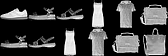

In [8]:
/* **
 * images0是batch tensor，是一个四维tensor，其大小为batch_size x channel x height x width
 * 使用chunk()将其拆散为batch_size个独立tensor，每个tensor是一幅独立图片，然后将这些tensor再组合
 * 成一个vector<torch::Tensor>;
 */
auto a = torch::chunk(images0, images0.size(0));
auto b = torch::chunk(labels0, labels0.size(0));

// 取出其中第一幅图像，其大小为 1 x 28 x 28，其中1是通道数
auto image = a[0].clone();
auto label = b[0].clone();

// printT(image.sizes());
// 使用squeeze()去除那些大小为1的维度，这里，会把图片的通道维度消除掉，仅剩下长、宽；
// permute()函数用于交换不同维度的顺序，这里用不到，如果是3通道图像，tensor的格式为
// C X H X W，此时需要借助permute()将其变为 H X W X C;
image = image.squeeze();//.permute({1,2,0});
// 因为在处理前对cvmat中的值做了归一化，所以现在要*255恢复，同时对于不在0-255范围内的数据，需要做限制
image *= 255;
image = torch::clamp(image, 0, 255);
// 原数据类型为float，为适应cv Mat的数据类型（CV_8UC1），需要转换为unsigned char;
image = image.to(torch::kU8);

// printT(image);
show_images(a, b, text_labels);
auto simg = im::image("test.png");
simg

sneaker		sandal		sandal		dress		t-shirt		bag		
sandal		sandal		dress		t-shirt		bag		pullover		


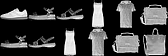

In [9]:
auto result = net(images0);

auto tt = result.max(1);
auto aa = std::get<0>(tt);
auto bb = std::get<1>(tt); //index

// printT(aa.dim());
// printT(bb.dim());
// printT(aa);
// printT(bb);

auto c = torch::chunk(images0, images0.size(0));
auto d = torch::chunk(bb, bb.size(0));
show_images(c, d, text_labels);
auto simg = im::image("test.png");
simg

/* 
 * 经过30个轮次的训练，识别结果还是有个别错误
 */